In [155]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from numpy import savetxt

In [156]:
df_train = pd.read_csv("/kaggle/input/les-variables-des-images-de-publicit/data_train.csv", sep='\t') #dataframe object

In [157]:
# Select duplicate rows except first occurrence based on all columns:
df_duplicateRows = df_train[df_train.duplicated()]
# print("Duplicate rows:", df_duplicateRows)
# print(df_duplicateRows.shape[0]) # 564 rows / 2459 rows

# Remove duplicate rows:
df_train = df_train.drop_duplicates()
# print(df_train.shape)

In [158]:
print(df_train.head())

     X1     X2      X3   X4  X5  X6  X7  X8  X9  X10  ...  X1550  X1551  \
1  33.0  230.0  6.9696  1.0   0   0   0   0   0    0  ...      0      0   
2  60.0  468.0  7.8000  1.0   0   0   0   0   0    0  ...      0      0   
3  60.0  468.0  7.8000  1.0   0   0   0   0   0    0  ...      0      0   
4  59.0  460.0  7.7966  1.0   0   0   0   0   0    0  ...      0      0   
5  60.0  234.0  3.9000  1.0   0   0   0   0   0    0  ...      0      0   

   X1552  X1553  X1554  X1555  X1556  X1557  X1558  outcome  
1      0      0      0      0      0      0      0      ad.  
2      0      0      0      0      0      0      0      ad.  
3      0      0      0      0      0      0      0      ad.  
4      0      0      0      0      0      0      0      ad.  
5      0      0      0      0      0      0      0      ad.  

[5 rows x 1559 columns]


## **1. Data Preprocessing**

### **1.1. Preprocessing of training data**

#### X4 = X3 / X2 -> remove X4 column :

In [159]:
df_train = df_train.drop(columns=['X4'])
df_train.head()

,X1,X2,X3,X5,X6,X7,X8,X9,X10,X11,...,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558,outcome
1,33.0,230.0,6.9696,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,60.0,468.0,7.8000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60.0,468.0,7.8000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,59.0,460.0,7.7966,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60.0,234.0,3.9000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


#### Ratio of the missing values:

In [160]:
# get the number of missing data points per column
missing_values_count = df_train.isna().sum()
print("missing values count:\n", missing_values_count)

# how many total missing values do we have?
total_cells = np.product(df_train.shape)
total_missing = missing_values_count.sum()

print("total_cells:", total_cells)
print("total_missing:",total_missing)

missing values count:
 X1         386
X2         382
X3         390
X5           0
X6           0
          ... 
X1555        0
X1556        0
X1557        0
X1558        0
outcome      0
Length: 1558, dtype: int64
total_cells: 2955526
total_missing: 1158


#### Fill the missing values in first three columns and with the median of these columns:

In [161]:
median_x2 = df_train['X1'].median()
median_x3 = df_train['X2'].median()
median_x5 = df_train['X3'].median()

# print("median_x2:", median_x2) # 60.0
# print("median_x3:", median_x3) # 114.0
# print("median_x5:", median_x5) # 1.0

df_train['X1'].fillna(median_x2, inplace=True)
df_train['X2'].fillna(median_x3, inplace=True)
df_train['X3'].fillna(median_x5, inplace=True)

### **1.2. Preprocessing of test data**

In [162]:
df_test = pd.read_csv("/kaggle/input/les-variables-des-images-de-publicit/data_test.csv", sep='\t') 

In [163]:
df_test = df_test.drop(columns=['X4']) # removed the redundant column X4
df_test.head()

,X1,X2,X3,X5,X6,X7,X8,X9,X10,X11,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
2460,125.0,125.0,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2461,57.0,468.0,8.2105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2462,60.0,468.0,7.8000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2463,125.0,125.0,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2464,30.0,585.0,19.5000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
df_nans = df_test[df_test.isnull().any(axis=1)] # 394 rows have one or more NaN values
print(df_nans)

median_x2_t = df_test['X1'].median()
median_x3_t = df_test['X2'].median()
median_x5_t = df_test['X3'].median()

# print("median_x2:", median_x2_t) # 52.0
# print("median_x3:", median_x3_t) # 110.5
# print("median_x5:", median_x5_t) # 1.0

df_test['X1'].fillna(median_x2_t, inplace=True)
df_test['X2'].fillna(median_x3_t, inplace=True)
df_test['X3'].fillna(median_x5_t, inplace=True)

      X1  X2  X3  X5  X6  X7  X8  X9  X10  X11  ...  X1549  X1550  X1551  \
2467 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
2475 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
2477 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
2486 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
2487 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...    ...    ...    ...   
3270 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
3273 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
3274 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
3276 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   
3278 NaN NaN NaN   0   0   0   0   0    0    0  ...      0      0      0   

      X1552  X1553  X1554  X1555  X1556  X1557  X1558  
2467      0      0      0      

In [165]:
df_test.head() 

,X1,X2,X3,X5,X6,X7,X8,X9,X10,X11,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
2460,125.0,125.0,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2461,57.0,468.0,8.2105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2462,60.0,468.0,7.8000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2463,125.0,125.0,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2464,30.0,585.0,19.5000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### While applying dimensionality reduction, first we fit the model using training data, and then we can use to transform the training and validation data.
#### (We can't apply oversampling to validation data.)

### **1. 3. Dimensionality reduction of training and test data**

#### **1. 3. 1. SVD for the dimensionality reduction of sparse boolean features** 

#### "Singular Value Decomposition, or SVD, is one of the most popular techniques for dimensionality reduction for sparse data (data with many zero values)."
#### https://machinelearningmastery.com/dimensionality-reduction-algorithms-with-python/
#### https://machinelearningmastery.com/singular-value-decomposition-for-dimensionality-reduction-in-python/

#### Creating two dataframes, as the first part is continuous variables (floating) and the second part is boolean variables :

In [166]:
df_train_fl = df_train.iloc[: , :3]
# print("df_pubData_Train_fl:\n", df_train_fl.head())

df_train_bool = df_train.iloc[: , 3:]
# print("boolean dataframe:\n", df_train_bool.head())

#### Same division of dataframes for the test data:

In [167]:
df_test_fl = df_test.iloc[: , :3]
print("df_pubData_Train_fl:\n", df_test_fl.head())

df_test_bool = df_test.iloc[: , 3:]
print("boolean dataframe:\n",df_test_bool.head())

df_pubData_Train_fl:
          X1     X2       X3
2460  125.0  125.0   1.0000
2461   57.0  468.0   8.2105
2462   60.0  468.0   7.8000
2463  125.0  125.0   1.0000
2464   30.0  585.0  19.5000
boolean dataframe:
       X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  ...  X1549  X1550  X1551  \
2460   0   0   0   0   0    0    0    0    0    0  ...      0      0      0   
2461   0   0   0   0   0    0    0    0    0    0  ...      0      0      0   
2462   0   0   0   0   0    0    0    0    0    0  ...      0      0      0   
2463   0   0   0   0   0    0    0    0    0    0  ...      0      0      0   
2464   0   0   0   0   0    0    0    0    0    0  ...      0      0      0   

      X1552  X1553  X1554  X1555  X1556  X1557  X1558  
2460      0      0      0      0      0      0      0  
2461      0      0      0      0      0      0      0  
2462      0      0      0      0      0      0      0  
2463      0      0      0      0      0      0      0  
2464      0      0      0      0   

#### Separating label column from training boolean dataframe:

In [168]:
label_train = df_train_bool.iloc[: , -1:] 
# label_train.shape # (1895, 1)
print(label_train.value_counts()) # 0: 1585, 1: 312

# drop the "outcome" column (binary label column):
df_train_bool = df_train_bool.iloc[: , :-1] 
df_train_bool.head()
# df_pubData_bool.shape # (1895, 1556)

outcome
nonad.     1585
ad.         312
dtype: int64


,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **1. 3. 2. Optimizing "n_components" parameter in TruncatedSVD**

#### The script below belongs to Chris Albon: https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

In [169]:
from sklearn.decomposition import TruncatedSVD

# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=df_train_bool.shape[1]-1)
X_tsvd = tsvd.fit(df_train_bool)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

# Calculating number of components required to pass threshold
def select_n_components(var_ratio, goal_var: float) -> int:

    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        
        if total_variance >= goal_var:
            break
            
    return n_components

# select_n_components(tsvd_var_ratios, 0.95) # 272

#### **1. 3. 3. Applying SVD encoding to boolean dataframes:**

In [170]:
SVD_model = TruncatedSVD(n_components=272).fit(df_train_bool)
print(df_train_bool.shape)
print(df_test_bool.shape)

df_train_bool_reduced = pd.DataFrame(SVD_model.transform(df_train_bool)) # pd.DataFrame is used to retain as data frame object
print(df_train_bool_reduced.shape)
# apply same transformation to df_test to boolean:

df_test_bool_reduced = pd.DataFrame(SVD_model.transform(df_test_bool))
print(df_test_bool_reduced.shape)

(1897, 1554)
(820, 1554)
(1897, 272)
(820, 272)


In [171]:
df_test_bool_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
0,0.084330,0.849064,0.060111,0.039712,0.467341,0.678603,0.579732,-0.336143,0.167077,0.054894,...,-0.110462,-0.115288,0.112915,0.057860,-0.129492,-0.038475,0.041237,-0.082857,-0.003603,0.031184
1,0.024535,0.310559,0.030505,0.001120,0.122168,0.156098,0.105392,-0.107590,0.276495,0.139799,...,-0.106966,0.019449,0.010407,0.015626,-0.024075,-0.009052,0.204342,-0.040130,0.027444,0.073546
2,0.258273,0.194337,0.837467,-0.645901,-0.202498,0.305489,-0.128264,-0.651823,0.183662,0.200322,...,-0.016937,0.019164,-0.015353,0.003041,0.026880,-0.039749,0.002051,0.040530,-0.025663,-0.012924
3,0.038342,1.242480,-0.328291,0.128119,0.043256,0.238941,0.571138,-0.319662,-0.158803,-0.105566,...,-0.039777,-0.034764,0.016878,-0.061301,0.108037,-0.056256,0.094449,0.094753,-0.055318,-0.065778
4,0.249433,0.448789,0.588882,-0.446252,-0.034502,0.405602,0.114033,-0.444107,0.090633,0.085379,...,0.068846,0.006947,0.061726,-0.096065,-0.009628,-0.040152,0.104680,-0.006122,0.115578,0.090296


#### Putting dataframes of test data together:

In [172]:
# indexes are not matching after preprocessing so we need to drop:
df_test_bool_reduced.reset_index(drop=True, inplace=True)
df_test_fl.reset_index(drop=True, inplace=True)

# concatenation of boolean with numeric test dataframes:
x_test = pd.concat( [df_test_fl, df_test_bool_reduced], axis=1 )
print((x_test.shape)) # (820, 275)
x_test.head()

(820, 275)


,X1,X2,X3,0,1,2,3,4,5,6,...,262,263,264,265,266,267,268,269,270,271
0,125.0,125.0,1.0000,0.084330,0.849064,0.060111,0.039712,0.467341,0.678603,0.579732,...,-0.110462,-0.115288,0.112915,0.057860,-0.129492,-0.038475,0.041237,-0.082857,-0.003603,0.031184
1,57.0,468.0,8.2105,0.024535,0.310559,0.030505,0.001120,0.122168,0.156098,0.105392,...,-0.106966,0.019449,0.010407,0.015626,-0.024075,-0.009052,0.204342,-0.040130,0.027444,0.073546
2,60.0,468.0,7.8000,0.258273,0.194337,0.837467,-0.645901,-0.202498,0.305489,-0.128264,...,-0.016937,0.019164,-0.015353,0.003041,0.026880,-0.039749,0.002051,0.040530,-0.025663,-0.012924
3,125.0,125.0,1.0000,0.038342,1.242480,-0.328291,0.128119,0.043256,0.238941,0.571138,...,-0.039777,-0.034764,0.016878,-0.061301,0.108037,-0.056256,0.094449,0.094753,-0.055318,-0.065778
4,30.0,585.0,19.5000,0.249433,0.448789,0.588882,-0.446252,-0.034502,0.405602,0.114033,...,0.068846,0.006947,0.061726,-0.096065,-0.009628,-0.040152,0.104680,-0.006122,0.115578,0.090296


### **1. 4. Balancing the highly imbalanced dataset**

#### **1. 4. 1. Visualizing the ratio of classes**

Class 0: 1585
Class 1: 312
Proportion: 5.08 : 1


<AxesSubplot:title={'center':'Count (target)'}>

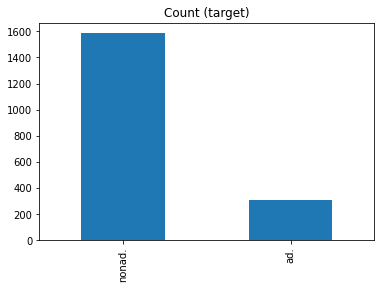

In [173]:
target_count = df_train.outcome.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

#### **1. 4. 2. Applying several oversampling methods and comparing**

In [174]:
# oversample = RandomOverSampler(sampling_strategy='minority')
# x_over, y_over = oversample.fit_resample(df_train_bool, label_train)

# sm = SMOTE(random_state = 42)
# x_sm, y_sm = sm.fit_resample(df_train_bool, label_train)

# sm = ADASYN()
# x_syn, y_syn = sm.fit_resample(df_train_bool, label_train)

# print("sizes before:", df_train_bool.shape, label_train.shape)
# print("sizes after RandomOverSampler resampling:",x_over.shape, y_over.shape)
# print("sizes after SMOTE resampling:",x_sm.shape, y_sm.shape)
# print("sizes after ADASYN resampling:",x_syn.shape, y_syn.shape)

In [175]:
# # define the pipeline
# steps = [('svd', TruncatedSVD(n_components=272)), ('m', LogisticRegression())] 
# model = Pipeline(steps=steps)

# # evaluate model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# y_pred_ROS = cross_val_predict(model, x_over, y_over, cv=cv, n_jobs=-1) # 0.97 recall for nonad
# print("classification report after RandomOverSampler:\n", classification_report(y_over, y_pred_ROS))

# y_pred_sm = cross_val_predict(model, x_sm, y_sm, cv=cv, n_jobs=-1)
# print("classification report after SMOTE:\n", classification_report(y_sm, y_pred_sm))

# y_pred_syn = cross_val_predict(model, x_syn, y_syn, cv=cv, n_jobs=-1)
# print("classification report after ADASYN:\n", classification_report(y_syn, y_pred_syn))

#### RandomOverSampler gives the highest recall and f1-score, so we will apply it to boolean datasets

In [176]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_over_bool, y_over = oversample.fit_resample(df_train_bool_reduced, label_train) # df_train_bool_reduced before oversampling: (1897, 272), label_train: (1897, 1)
print((x_over_bool.shape), (y_over.shape))

(3170, 272) (3170, 1)


#### Dataframe sizes before oversampling: (1897, 272), (1897, 1) ; after oversampling: (3170, 272), (3170, 1)

In [177]:
# oversampling of floating dataframe:
x_over_fl, y_over = oversample.fit_resample(df_train_fl, label_train)
print((x_over_fl.shape), (y_over.shape))

(3170, 3) (3170, 1)


#### Putting dataframes of train data together:

In [178]:
# concatenation of boolean with numeric training dataframes:
x_over = pd.concat( [x_over_fl, x_over_bool], axis=1 )
print((x_over.shape))
x_over.head()

(3170, 275)


,X1,X2,X3,0,1,2,3,4,5,6,...,262,263,264,265,266,267,268,269,270,271
0,33.0,230.0,6.9696,0.269646,0.212087,0.842325,-0.626162,-0.236919,0.354537,-0.155154,...,-0.047185,0.024108,-0.107433,0.074018,-0.054194,0.033636,-0.089407,0.041421,-0.226590,0.022456
1,60.0,468.0,7.8000,0.271145,0.454056,0.847042,-0.625592,-0.039481,0.563737,0.074290,...,0.110011,-0.098996,0.065217,0.043981,-0.103186,0.196302,-0.170964,-0.030659,0.043512,-0.124555
2,60.0,468.0,7.8000,0.249070,0.191807,0.827824,-0.641396,-0.204237,0.312661,-0.148357,...,-0.060541,0.021195,0.012711,-0.118403,-0.043371,-0.001180,0.119325,-0.051543,0.109648,0.101428
3,59.0,460.0,7.7966,0.388725,0.307679,1.199036,-0.599964,0.122520,0.221486,-0.134222,...,-0.105000,-0.007670,0.051095,0.050355,0.048169,-0.096944,0.055253,0.043442,-0.127817,-0.080637
4,60.0,234.0,3.9000,0.190661,4.596122,-0.628253,0.145598,-0.276105,-0.254229,-0.199289,...,-0.010224,-0.000733,-0.049306,0.063816,-0.087670,0.065506,-0.082761,-0.065378,0.037030,-0.047594


## **2. Applying cross validation**

In [179]:
model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
y_pred_ROS = cross_val_predict(model, x_over, y_over, cv=cv, n_jobs=-1) 
print("classification report:\n", classification_report(y_over, y_pred_ROS))

classification report:
               precision    recall  f1-score   support

         ad.       0.96      0.93      0.94      1585
      nonad.       0.93      0.96      0.95      1585

    accuracy                           0.95      3170
   macro avg       0.95      0.95      0.95      3170
weighted avg       0.95      0.95      0.95      3170



## **3. Predictions based on several models**

### **3. 1. Fitting a logistic regression model**

In [180]:
print(x_over.shape)
print(y_over.shape)

(3170, 275)
(3170, 1)


In [181]:
logreg_model = LogisticRegression()
logreg_model.fit(x_over, y_over)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

#### Predicting the test set results:

In [182]:
y_pred = logreg_model.predict(x_test) # output: numpy.ndarray

In [183]:
# save to csv file
savetxt('y_pred.csv', y_pred, delimiter=',', fmt=('%s'))

### **3. 2. Fitting a deep neural network model**